# Objective

Our task is to predict survival of patients suffering from coronary artery disease(s) from the dataset given.

I will explore the dataset to check
- Features and the Target
- Distribution of the data
- Null/missing data (explicit or implicit)

Having a good sense of the data given I will do
- feature engineering
- feature selection

,based on what I understand about the data and construct pipelines

Lastly I will 
- come up with preliminary models 
- shortlist 3 models against validation data
- hyper parameter tunning for shortlisted models

Out of the 3 I will choose 1 model to be deployed in production

# Imports

In [1]:
import sqlite3 as sq3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

RANDOM_SEED = 42
CV = 5
TEST_RATIO = 0.5
VAL_RATIO = 0.2

In [2]:
DB_PATH = 'Data/survive.db'
con = sq3.Connection(DB_PATH)
query = '''SELECT * FROM SURVIVE'''
df = pd.read_sql(query, con)

# EDA

| Feature | Description | Expected Value Type | Expected Example | 
| --- | --- | --- | --- |
|ID|	Unique ID for each patient| (int) | 1245 |
|Survive	| Whether Patient Survives, 0= No, 1=Yes| (int/boolean) | 0,1,Yes,No |
| Diabetes | Diabetes condition of patient | (int/boolean) | yes, No| 
|Gender	|Gender	|  (int/boolean) | 0,1,M,F |
|Smoke	|Smoker	| (int/boolean) | 0,1,Yes,No |
|Age	|Age of patient	| (int) | 32 | 
|Ejection Fraction	| Strength of heart	| (float) | 0.5 to 0.75, bounded[0,1] |  
|Sodium	|level of sodium in blood serum (mg/dL)	| (int) | 135-145 millimoles per litre (mmol/L) | 
|Creatinine	|level of Creatinine in blood serum (md/dL)	|  (int) | For adult men, 0.74 to 1.35 mg/dL , For adult women, 0.59 to 1.04 mg/dL |
|Pletelets	|Number of platelets in the blood serum (kilo-platelets/mL)	| (int) | 150K to 450K platelets per microliter of blood |
|Creatinine Phosphokinase|	level of the enzyme in the blood (mcg/L)| (int) |  10 to 120 micrograms per liter (mcg/L)
|Blood Pressure | level of blood pressure(mmHG) | (int) | systolic pressure of less than 120 and a diastolic pressure of less than 80 |
|Hemoglobin| level of hemoglobin in blood (g/dL) | (float) | For men, 13.5 to 17.5 grams per deciliter. For women, 12.0 to 15.5 grams per deciliter|
|Height| height of patient (cm)| (float) | 166cm |
|Weight| weight of patient (kg) | (float) | 58kg |
|Favourite Color | Patient's Favourite Color | (str) | blue | 

Some research was needed to form some expected values and types of the features I am going to look at. This is important because some values can be implicit without some domain knowledge. As much as I can, I will need to be able to detect them and impute them as best as I can. Expected value / sensible range for features like Creatinine and other medical terms can be found in google. However as the information gathered from the internet are for normal range of values whereas the dataset consist of data from patients, the range of values can differ.

Blood pressure should be given as two set of numbers one as systolic pressure and another as diastolic pressure.

In [3]:
# making copy of dataframe just in case
df_ori = df.copy()

Certain features like ID and favourite color has no bearing on the outcome of the patient's survivability so these will be dropped immediately.

In [4]:
df.drop(columns=['ID', 'Favorite color'], inplace = True)

In [5]:
# Checking the dtype of features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Survive                   15000 non-null  object 
 1   Gender                    15000 non-null  object 
 2   Smoke                     15000 non-null  object 
 3   Diabetes                  15000 non-null  object 
 4   Age                       15000 non-null  int64  
 5   Ejection Fraction         15000 non-null  object 
 6   Sodium                    15000 non-null  int64  
 7   Creatinine                14501 non-null  float64
 8   Pletelets                 15000 non-null  float64
 9   Creatinine phosphokinase  15000 non-null  int64  
 10  Blood Pressure            15000 non-null  int64  
 11  Hemoglobin                15000 non-null  float64
 12  Height                    15000 non-null  int64  
 13  Weight                    15000 non-null  int64  
dtypes: flo

Survive is the target, we have a bunch of features that are strings, some are integers and a couple of floats.

One unexpected feature is diabetes because it was not in the original list of features we are expecting. 

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,15000.0,57.428467,23.411173,-95.0,50.0,60.0,70.0,95.0
Sodium,15000.0,136.604267,4.364890,113.0,134.0,137.0,140.0,148.0
Creatinine,14501.0,1.410195,1.044535,0.5,0.9,1.1,1.4,9.4
Pletelets,15000.0,263096.016490,98056.330340,25100.0,211000.0,262000.0,304000.0,850000.0
Creatinine phosphokinase,15000.0,580.151800,955.418765,23.0,115.0,250.0,582.0,7861.0
Blood Pressure,15000.0,103.676667,39.700138,40.0,70.0,100.0,137.0,179.0
Hemoglobin,15000.0,12.910667,2.500152,9.0,10.7,12.7,15.1,17.5
Height,15000.0,159.475200,17.344439,130.0,144.0,160.0,174.0,189.0
Weight,15000.0,69.340467,25.298287,19.0,50.0,66.0,87.0,141.0


Some values already seem suspect like the height and weight. We will look at the distributions later

In [7]:
df.select_dtypes(include ='object').describe().T

,count,unique,top,freq
Survive,15000,4,0,9581
Gender,15000,2,Male,9757
Smoke,15000,4,No,9710
Diabetes,15000,3,Normal,8789
Ejection Fraction,15000,5,Low,12734


Survive is our target variable and it has 4 unique values. Smoke has similar quality. Ejection fraction was expected as a float but was given as a categorical.

We will need to inspect them further

In [8]:
df.head(10)

,Survive,Gender,Smoke,Diabetes,Age,Ejection Fraction,Sodium,Creatinine,Pletelets,Creatinine phosphokinase,Blood Pressure,Hemoglobin,Height,Weight
0,0,Male,Yes,Normal,50,Low,141,0.70,266000.0,185,105,12.3,180,93
1,1,Male,No,Normal,75,Low,134,2.50,224000.0,99,162,13.0,140,47
2,1,Female,No,Pre-diabetes,80,Low,135,1.30,192000.0,776,179,12.4,150,61
3,0,Male,No,Normal,-60,Low,136,0.90,228000.0,2261,136,15.3,130,48
4,0,Female,No,Normal,70,Low,141,0.90,358000.0,1202,171,13.3,177,64
5,1,Male,No,Normal,55,Low,138,1.10,314000.0,2017,88,16.5,176,58
6,1,Male,No,Normal,75,Low,134,2.50,224000.0,99,164,16.3,172,70
7,0,Female,No,Normal,65,Low,139,1.70,294000.0,326,82,14.1,167,50
8,No,Female,No,Pre-diabetes,60,Low,140,0.75,228000.0,96,83,15.5,176,94
9,1,Female,No,Normal,60,Low,127,1.70,62000.0,166,59,12.3,156,47


We see age containing negative number which is invalid.

In [9]:
df.isna().sum()

Survive                       0
Gender                        0
Smoke                         0
Diabetes                      0
Age                           0
Ejection Fraction             0
Sodium                        0
Creatinine                  499
Pletelets                     0
Creatinine phosphokinase      0
Blood Pressure                0
Hemoglobin                    0
Height                        0
Weight                        0
dtype: int64

Only creatinine has explicit invalid/ null values

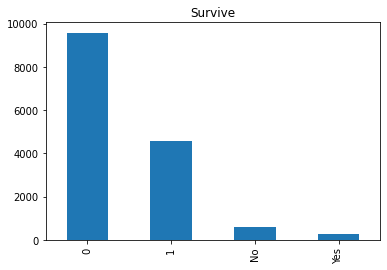

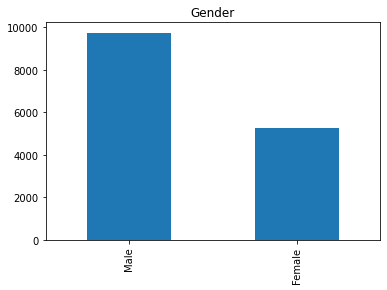

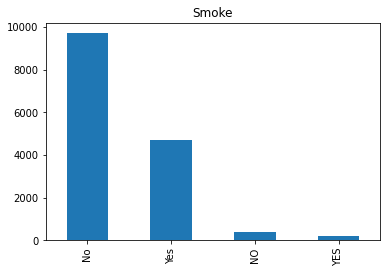

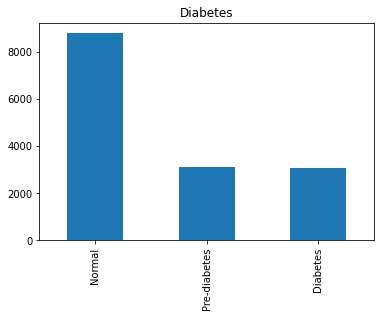

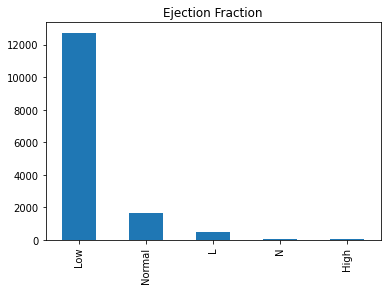

In [10]:
for col in df.select_dtypes(include='object'):
    df[col].value_counts().plot(kind='bar')
    df[col].value_counts()
    plt.title(col)
    plt.show()

We have a closer look at the categorical features. Our target feature is still binary, we just need to transform the string into numbers. The same can be done to smoke. Ejection fraction will also need some cleaning.

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Sodium'}>,
        <AxesSubplot:title={'center':'Creatinine'}>],
       [<AxesSubplot:title={'center':'Pletelets'}>,
        <AxesSubplot:title={'center':'Creatinine phosphokinase'}>,
        <AxesSubplot:title={'center':'Blood Pressure'}>],
       [<AxesSubplot:title={'center':'Hemoglobin'}>,
        <AxesSubplot:title={'center':'Height'}>,
        <AxesSubplot:title={'center':'Weight'}>]], dtype=object)

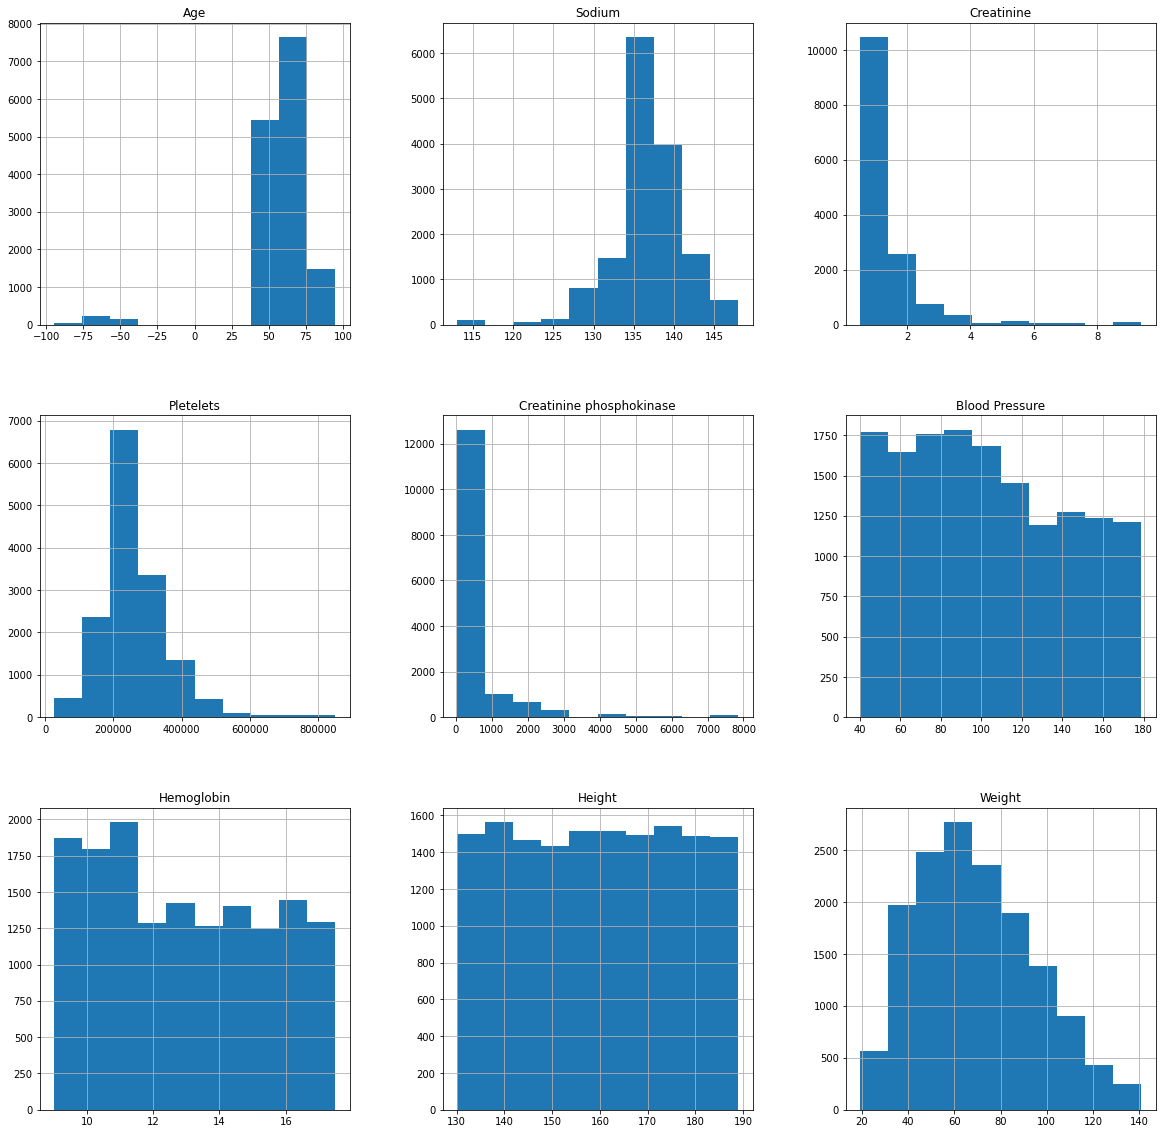

In [11]:
df.hist(figsize = (20,20))

We have already seen that the age has some invalid values. My assumption here is that the value is correct but the sign is flipped.

Some of the features look normal/guassian but others are tail heavy.

Height and BP has a uniform distribution

In [12]:
df_ori.columns.to_list()

['ID',
 'Survive',
 'Gender',
 'Smoke',
 'Diabetes',
 'Age',
 'Ejection Fraction',
 'Sodium',
 'Creatinine',
 'Pletelets',
 'Creatinine phosphokinase',
 'Blood Pressure',
 'Hemoglobin',
 'Height',
 'Weight',
 'Favorite color']

<b>Observations</b>:

Survive
- mixed types present : 0,1, yes , no 

Gender
- seems okay

Smoke
- inconsistent case No vs NO

Diabetes
- seems okay

Age
- Some values of age appears to be invalid (min -95?), could possibly be 95 instead of 95
- I will assume that the negative sign is a typo or some calculation error but the value is correct

Ejection Fraction
- I was expecting float but categories were given, categories are inconsistent

Sodium
- Sodium appears to be in range, with some outliers

Creatinine
- Some values of creatinine appears to be invalid (max 9.4?)
- only feature with explicit na values

Pletelets
- Pletelets??

Creatinine phosphokinase (CK)
- CK appears to be too much. Are they in different units?
- Some outliers

Blood Pressure
- Blood pressure is typically measured with 2 set of values but only 1 is present without specifying which

Hemoglobin
- Hemoglobin appears to be in range

Height
- Lower end of height appears to be low considering age of patients

Weight
- Some values of weight appears to be invalid (min 19kg?)

# Cleaning up the dataset

Based on the observations above, we will clean up the features one by one in the sequence they appear in the columns starting with the target.

## Target - Survive

Problems
- mixed types present : 0,1, yes , no

For survive it is stated that if the patient survives: 0 = No , 1 = Yes, hence we will replace No to 0 and Yes to 1 instead of 0 to No and 1 to Yes since we will encode them to numbers anyway

In [13]:
df.Survive.value_counts()

0      9581
1      4552
No      604
Yes     263
Name: Survive, dtype: int64

In [14]:
df.Survive.str.replace('No','0').value_counts()

0      10185
1       4552
Yes      263
Name: Survive, dtype: int64

In [15]:
df.Survive = df.Survive.str.replace('No','0')

In [16]:
df.Survive.str.replace('Yes','1').value_counts()

0    10185
1     4815
Name: Survive, dtype: int64

In [17]:
df.Survive = df.Survive.str.replace('Yes','1')

In [18]:
df.Survive.value_counts(normalize=True)

0    0.679
1    0.321
Name: Survive, dtype: float64

In [19]:
df.Survive = df.Survive.astype('int')

The Dataset is not too imbalanced like 0.9 against 0.1 we may not need to down or up sample.

## Gender

Gender seems okay

In [20]:
df.Gender.value_counts(normalize=True)

Male      0.650467
Female    0.349533
Name: Gender, dtype: float64

## Smoker

Problem: inconsistent case No vs NO

In [21]:
df.Smoke.value_counts()

No     9710
Yes    4707
NO      399
YES     184
Name: Smoke, dtype: int64

In [22]:
df.Smoke = df.Smoke.replace('NO','No')
df.Smoke = df.Smoke.replace('YES','Yes')

In [23]:
df.Smoke.value_counts(normalize=True)

No     0.673933
Yes    0.326067
Name: Smoke, dtype: float64

## Diabetes

In [24]:
df.Diabetes.value_counts(normalize=True)

Normal          0.585933
Pre-diabetes    0.208267
Diabetes        0.205800
Name: Diabetes, dtype: float64

## Age
Problem: Some values of age appears to be invalid (min -95?), could possibly be 95 instead of 95

In [25]:
df[df.Age < 0]

,Survive,Gender,Smoke,Diabetes,Age,Ejection Fraction,Sodium,Creatinine,Pletelets,Creatinine phosphokinase,Blood Pressure,Hemoglobin,Height,Weight
3,0,Male,No,Normal,-60,Low,136,0.90,228000.00,2261,136,15.3,130,48
14,0,Male,No,Normal,-40,Low,137,0.90,255000.00,129,82,9.1,140,37
24,1,Male,Yes,Normal,-85,Low,132,1.00,243000.00,5882,79,15.2,160,84
112,1,Male,No,Normal,-45,Low,135,1.60,126000.00,582,130,12.7,177,69
119,0,Female,No,Diabetes,-58,Normal,137,0.80,300000.00,200,53,9.1,155,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14937,1,Female,No,Normal,-86,Low,134,1.83,263358.03,582,58,12.8,137,57
14959,0,Male,Yes,Normal,-50,Normal,140,NaN,147000.00,582,129,14.2,143,43
14961,0,Female,No,Diabetes,-50,Low,134,1.00,279000.00,582,135,9.3,171,63
14987,0,Female,Yes,Normal,-70,Normal,140,0.80,317000.00,92,165,16.0,168,92


We have 430 rows where age is negative. I think its highly likely that they age could be positive instead without changing the value, lets see if it makes sense

In [26]:
df[df.Age<0].sample(5, random_state= RANDOM_SEED)

,Survive,Gender,Smoke,Diabetes,Age,Ejection Fraction,Sodium,Creatinine,Pletelets,Creatinine phosphokinase,Blood Pressure,Hemoglobin,Height,Weight
14822,0,Male,Yes,Normal,-52,Low,140,0.9,325000.0,3966,47,12.5,177,80
2275,1,Female,Yes,Pre-diabetes,-50,Low,136,1.2,153000.0,124,130,17.3,189,131
5924,1,Male,No,Normal,-85,Low,132,3.0,360000.0,23,110,14.9,186,129
778,1,Male,No,Normal,-58,Low,134,5.8,153000.0,60,84,9.7,133,66
12956,1,Male,No,Normal,-80,Low,133,4.4,140000.0,553,143,9.1,155,86


<AxesSubplot:>

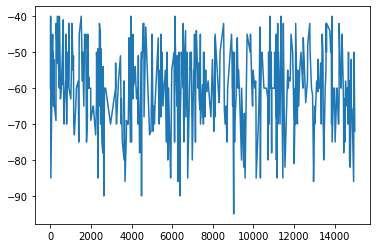

In [27]:
df[df.Age<0].loc[:,'Age'].plot()

they appear to be within normal range of values, between 40 to 90 and not like 200 or 0. We will flip the sign

In [28]:
# Flipping the sign if they are negative, else leave them be
df.Age = np.where(df.Age<0,-df.Age, df.Age)

In [29]:
# check if our code is correct, it should leave no age that are negative
df[df.Age<0]

,Survive,Gender,Smoke,Diabetes,Age,Ejection Fraction,Sodium,Creatinine,Pletelets,Creatinine phosphokinase,Blood Pressure,Hemoglobin,Height,Weight


<AxesSubplot:>

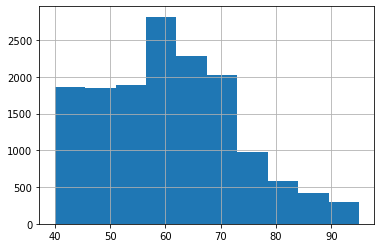

In [30]:
# Seems okay
df.Age.hist()

## Ejection Fraction
Problem : I was expecting float but categories were given, categories are inconsistent

In [31]:
df['Ejection Fraction'].value_counts()

Low       12734
Normal     1658
L           482
N            66
High         60
Name: Ejection Fraction, dtype: int64

N should be normal, L should be L and high should remain. 

In [32]:
df['Ejection Fraction'] = df['Ejection Fraction'].replace('L','Low').replace('N','Normal')

In [33]:
df['Ejection Fraction'].value_counts(normalize= True)

Low       0.881067
Normal    0.114933
High      0.004000
Name: Ejection Fraction, dtype: float64

High has too little count (0.0044% ) to make a difference and will be merged together with Normal to become normal. To reflect this change I will rename Normal to Normal-High

In [34]:
df['Ejection Fraction'] = df['Ejection Fraction'].replace('High','Normal').replace('Normal','Normal-High')

In [35]:
df['Ejection Fraction'].value_counts(normalize= True)

Low            0.881067
Normal-High    0.118933
Name: Ejection Fraction, dtype: float64

## Sodium
Problem: Sodium appears to be in range, with some outliers

<AxesSubplot:>

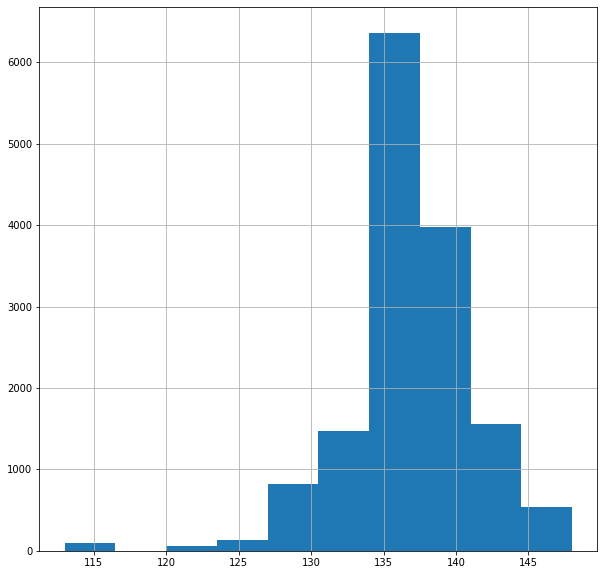

In [36]:
df.Sodium.hist(figsize = (10,10))

In [37]:
df.Sodium.describe().T

count    15000.000000
mean       136.604267
std          4.364890
min        113.000000
25%        134.000000
50%        137.000000
75%        140.000000
max        148.000000
Name: Sodium, dtype: float64

C:\Users\Randy\Venv\aiap\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Sodium'>

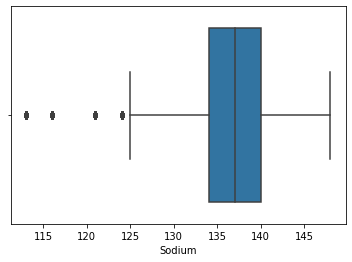

In [38]:
sns.boxplot(df.Sodium)

We have some outliers and they appear to only have 4 unqiue values. Lets eyeball them

In [39]:
df[df.Sodium< 125]

,Survive,Gender,Smoke,Diabetes,Age,Ejection Fraction,Sodium,Creatinine,Pletelets,Creatinine phosphokinase,Blood Pressure,Hemoglobin,Height,Weight
106,1,Female,No,Diabetes,65,Low,116,2.7,327000.00,160,72,9.8,135,71
107,1,Female,No,Pre-diabetes,48,Low,121,1.9,87000.00,582,67,9.9,155,92
149,1,Female,No,Pre-diabetes,65,Low,116,2.7,327000.00,160,53,9.6,139,76
224,1,Female,No,Pre-diabetes,65,Low,116,2.7,327000.00,160,106,9.6,166,108
263,1,Female,No,Diabetes,65,Low,116,2.7,327000.00,160,54,10.9,137,74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14509,1,Female,No,Diabetes,65,Low,116,2.7,327000.00,160,63,9.5,149,87
14636,0,Male,Yes,Diabetes,60,Low,113,1.8,263358.03,1211,59,14.3,134,38
14637,1,Female,No,Pre-diabetes,65,Low,116,2.7,327000.00,160,109,11.5,148,86
14819,1,Female,No,Diabetes,48,Low,121,1.9,87000.00,582,96,11.1,168,109


In [40]:
df[df.Sodium< 125]['Sodium'].value_counts()

121    55
116    53
113    41
124    36
Name: Sodium, dtype: int64

I'm not sure why the outliers occupy 4 unique values. But I am unable to discern any insights from these outliers. I will censor them and cap them at the minimum value. Let me define some helper functions to be consistent with my treatment of outliers unless I have other reasons to deviate from this.

In [41]:
def return_min_max_boxplot(df, col, min_or_max):
    """
    returns upper(max) or lower(min) of the inner fence boxplot value
    
    args:
    df : dataframe
    col: the col of the dataframe
    min_or_max : the upper(max) or lower(min) of the inner fence boxplot value
    
    returns: 
    (float) upper(max) or lower(min) of the inner fence boxplot value
    """
    df_col_q1 = np.quantile(df[col],0.25, method = 'midpoint')
    df_col_q3 = np.quantile(df[col],0.75, method = 'midpoint')
    df_col_itr = df_col_q3-df_col_q1
    df_col_min_cap = df_col_q1 - (1.5*df_col_itr)
    df_col_max_cap = df_col_q3 + (1.5*df_col_itr)
    if 'min' in min_or_max:
        return df_col_min_cap
    else : 
        return df_col_max_cap

In [42]:
def inspect_outliers(df, col):
    """
    inspects the outliers of the col of the dataframe provided, 
    displaying in dataframe format of the values considered outliers 
    which are beyond the inner fence boxplot values (1.5 times the inter-
    quartile range of either 1st quartile or 3rd quartile)
    
    args:
    df : dataframe
    col: the col of the dataframe
    
    returns: 
    none
    """
    df_col_max = return_min_max_boxplot(df, col, 'max')
    df_col_min = return_min_max_boxplot(df, col, 'min')
    print('Values > Outer Fence')
    display(df[df[col] >= df_col_max])
    print('\nValue Counts')
    print(df[df[col] >= df_col_max][col].value_counts())
    print('\nValues < Outer Fence \n')
    display(df[df[col] <= df_col_min])
    print('\nValue Counts')
    print(df[df[col] <= df_col_min][col].value_counts())
    print('\nDescribe')
    print(df[col].describe().T)
    sns.boxplot(df[col])

In [43]:
def bound_outliers(df, col, boxplot= True):
    """
    Censors outliers to within the boxplot inner fences and plots
    the boxplot afterwards if set to true

    args:
    df : dataframe
    col: the col of the dataframe
    
    returns:
    none
    """
    df_col_max = return_min_max_boxplot(df, col, 'max')
    df_col_min = return_min_max_boxplot(df, col, 'min')
    df[col] = np.where(df[col]>=df_col_max, df_col_max,df[col])
    df[col] = np.where(df[col]<=df_col_min, df_col_min,df[col])
    if boxplot:
        sns.boxplot(df[col])

C:\Users\Randy\Venv\aiap\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


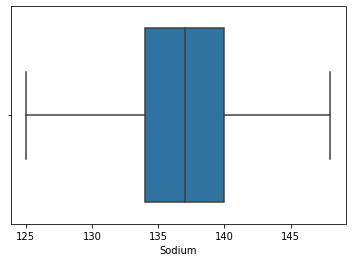

In [44]:
bound_outliers(df,'Sodium')

## Creatinine

Problems
- Some values of creatinine appears to be invalid (max 9.4?)
- only feature with explicit na values

In [45]:
df['Creatinine'].isna().sum()

499

In [46]:
df[df['Creatinine'].isna()]

,Survive,Gender,Smoke,Diabetes,Age,Ejection Fraction,Sodium,Creatinine,Pletelets,Creatinine phosphokinase,Blood Pressure,Hemoglobin,Height,Weight
23,0,Male,No,Normal,85,Low,134.0,NaN,235000.0,910,41,11.8,160,71
42,0,Male,No,Normal,70,Low,132.0,NaN,173000.0,232,87,15.1,181,62
66,0,Male,No,Pre-diabetes,70,Low,137.0,NaN,241000.0,2695,77,13.9,160,39
187,0,Female,No,Normal,65,Low,139.0,NaN,294000.0,326,49,14.0,174,54
220,0,Male,No,Diabetes,55,Low,135.0,NaN,336000.0,170,90,10.0,137,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14913,0,Male,Yes,Normal,69,Low,135.0,NaN,105000.0,1419,118,16.2,189,90
14935,0,Male,Yes,Normal,50,Low,136.0,NaN,395000.0,196,118,12.4,187,40
14959,0,Male,Yes,Normal,50,Normal-High,140.0,NaN,147000.0,582,129,14.2,143,43
14963,0,Male,Yes,Normal,53,Normal-High,133.0,NaN,220000.0,196,75,15.5,174,81


We have 499 na values. We will imput them with median value of Creatinine as mean will be weighted unevenly by outliers

In [47]:
Creatinine_median = df['Creatinine'].median()

In [48]:
df['Creatinine'].fillna(Creatinine_median, inplace= True)

In [49]:
# checking na values
df[df['Creatinine'].isna()]

,Survive,Gender,Smoke,Diabetes,Age,Ejection Fraction,Sodium,Creatinine,Pletelets,Creatinine phosphokinase,Blood Pressure,Hemoglobin,Height,Weight


In [50]:
df.Creatinine.dtype

dtype('float64')

C:\Users\Randy\Venv\aiap\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Creatinine', ylabel='Density'>

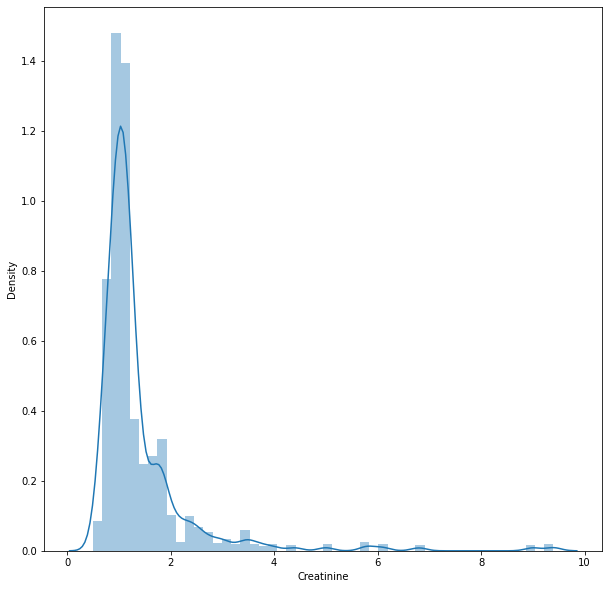

In [51]:
fig = plt.figure(figsize = (10,10))
sns.distplot(df['Creatinine'])

Values > Outer Fence


,Survive,Gender,Smoke,Diabetes,Age,Ejection Fraction,Sodium,Creatinine,Pletelets,Creatinine phosphokinase,Blood Pressure,Hemoglobin,Height,Weight
1,1,Male,No,Normal,75,Low,134.0,2.5,224000.0,99,162,13.0,140,47
6,1,Male,No,Normal,75,Low,134.0,2.5,224000.0,99,164,16.3,172,70
25,0,Male,No,Diabetes,60,Low,137.0,2.3,305000.0,2656,76,12.8,186,128
54,1,Female,No,Diabetes,60,Low,132.0,2.5,196000.0,76,115,10.5,179,103
59,0,Male,No,Pre-diabetes,60,Low,137.0,2.3,305000.0,2656,85,14.2,175,113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14957,1,Female,No,Normal,72,Low,135.0,2.5,235000.0,233,150,14.6,158,71
14965,0,Male,No,Normal,64,Low,135.0,2.4,246000.0,143,49,14.5,187,65
14966,1,Male,No,Normal,75,Low,134.0,2.5,224000.0,99,128,17.2,163,63
14967,1,Male,No,Normal,85,Low,132.0,3.0,360000.0,23,105,14.4,162,98



Value Counts
2.5    179
2.3    161
2.7    145
2.4    108
3.5    103
3.0     93
5.8     67
2.2     65
2.9     63
3.2     54
3.4     52
3.7     52
9.4     50
4.0     49
5.0     49
6.1     49
4.4     47
9.0     47
6.8     46
3.8     34
Name: Creatinine, dtype: int64

Values < Outer Fence 



,Survive,Gender,Smoke,Diabetes,Age,Ejection Fraction,Sodium,Creatinine,Pletelets,Creatinine phosphokinase,Blood Pressure,Hemoglobin,Height,Weight



Value Counts
Series([], Name: Creatinine, dtype: int64)

Describe
count    15000.000000
mean         1.399876
std          1.028518
min          0.500000
25%          0.900000
50%          1.100000
75%          1.400000
max          9.400000
Name: Creatinine, dtype: float64


C:\Users\Randy\Venv\aiap\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


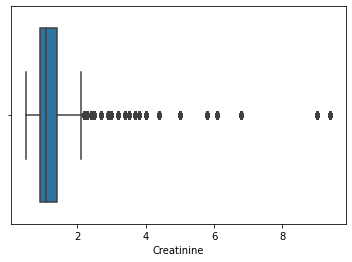

In [52]:
inspect_outliers(df,'Creatinine')

We have 1.5K plus outliers

According to https://www.emedicinehealth.com/creatinine_blood_tests/article_em.htm, 2 and above indicate abnormal readings with 5 indicating severe kidney damage. While we can assume if most of them have a pattern of entries like 9.4 which can be typos (0.94), it does not seem to be the case here. These can be actual readings without errors. I will cap them at the maximum

C:\Users\Randy\Venv\aiap\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


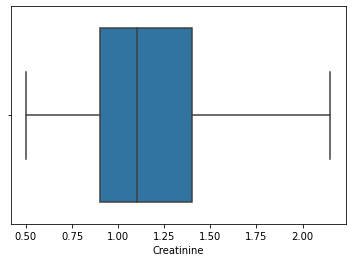

In [53]:
bound_outliers(df,'Creatinine')

## Pletelets

Pletelets

C:\Users\Randy\Venv\aiap\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Pletelets', ylabel='Density'>

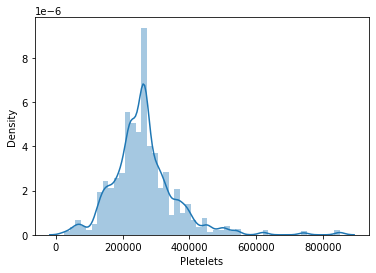

In [54]:
sns.distplot(df.Pletelets)

Values > Outer Fence


,Survive,Gender,Smoke,Diabetes,Age,Ejection Fraction,Sodium,Creatinine,Pletelets,Creatinine phosphokinase,Blood Pressure,Hemoglobin,Height,Weight
16,0,Female,No,Diabetes,70,Low,139.0,1.3,533000.0,81,145,16.0,157,46
33,0,Female,No,Diabetes,45,Low,132.0,1.0,543000.0,582,73,13.7,168,42
69,0,Female,No,Pre-diabetes,45,Normal-High,138.0,0.8,742000.0,2060,118,17.5,175,37
82,0,Male,Yes,Normal,78,Low,138.0,1.4,481000.0,224,41,15.0,133,37
100,1,Male,No,Normal,95,Low,132.0,2.0,461000.0,371,118,9.3,189,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14903,0,Male,Yes,Normal,78,Low,138.0,1.1,481000.0,224,70,15.9,159,53
14909,0,Female,No,Diabetes,70,Low,139.0,1.3,533000.0,81,156,12.2,135,34
14917,0,Male,Yes,Normal,78,Low,138.0,1.4,481000.0,224,111,12.2,164,56
14977,0,Male,Yes,Normal,78,Low,138.0,1.4,481000.0,224,61,13.0,156,51



Value Counts
451000.0    93
543000.0    61
481000.0    57
621000.0    56
850000.0    55
507000.0    55
454000.0    53
497000.0    50
504000.0    47
742000.0    46
448000.0    44
533000.0    43
461000.0    34
Name: Pletelets, dtype: int64

Values < Outer Fence 



,Survive,Gender,Smoke,Diabetes,Age,Ejection Fraction,Sodium,Creatinine,Pletelets,Creatinine phosphokinase,Blood Pressure,Hemoglobin,Height,Weight
9,1,Female,No,Normal,60,Low,127.0,1.70,62000.0,166,59,12.3,156,47
108,0,Male,No,Diabetes,70,Low,140.0,1.10,25100.0,582,116,13.3,153,36
145,0,Male,Yes,Normal,70,Low,136.0,2.15,51000.0,582,105,12.9,169,43
154,1,Female,No,Normal,60,Low,127.0,1.70,62000.0,166,119,16.3,145,41
252,1,Female,No,Normal,60,Low,127.0,1.70,62000.0,166,115,13.6,182,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14808,0,Male,Yes,Normal,70,Low,136.0,2.15,51000.0,582,116,13.0,179,48
14821,1,Female,No,Normal,60,Low,127.0,1.70,62000.0,166,45,15.3,130,33
14853,0,Male,Yes,Normal,70,Low,136.0,2.15,51000.0,582,67,14.1,138,29
14876,1,Female,No,Normal,60,Low,127.0,1.70,62000.0,166,68,15.8,184,65



Value Counts
62000.0    60
70000.0    55
25100.0    45
51000.0    44
47000.0    43
Name: Pletelets, dtype: int64

Describe
count     15000.00000
mean     263096.01649
std       98056.33034
min       25100.00000
25%      211000.00000
50%      262000.00000
75%      304000.00000
max      850000.00000
Name: Pletelets, dtype: float64


C:\Users\Randy\Venv\aiap\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


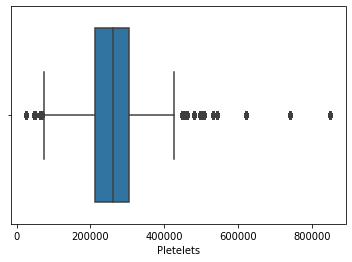

In [55]:
inspect_outliers(df,'Pletelets')

I will cap the min and max accordingly

C:\Users\Randy\Venv\aiap\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


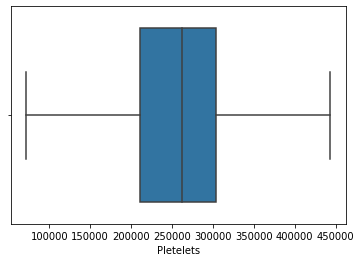

In [56]:
bound_outliers(df,'Pletelets')

## Creatinine phosphokinase

Values > Outer Fence


,Survive,Gender,Smoke,Diabetes,Age,Ejection Fraction,Sodium,Creatinine,Pletelets,Creatinine phosphokinase,Blood Pressure,Hemoglobin,Height,Weight
3,0,Male,No,Normal,60,Low,136.0,0.90,228000.0,2261,136,15.3,130,48
5,1,Male,No,Normal,55,Low,138.0,1.10,314000.0,2017,88,16.5,176,58
24,1,Male,Yes,Normal,85,Low,132.0,1.00,243000.0,5882,79,15.2,160,84
25,0,Male,No,Diabetes,60,Low,137.0,2.15,305000.0,2656,76,12.8,186,128
27,0,Male,Yes,Normal,45,Low,140.0,1.40,140000.0,2413,108,15.3,134,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14925,0,Female,No,Normal,55,Low,139.0,1.20,270000.0,1820,95,15.2,140,25
14932,0,Male,No,Pre-diabetes,60,Low,137.0,2.15,305000.0,2656,78,12.1,151,84
14940,1,Male,No,Diabetes,45,Low,139.0,1.10,334000.0,2442,78,13.2,178,86
14950,0,Male,Yes,Normal,69,Low,135.0,1.00,105000.0,1419,48,14.6,140,50



Value Counts
2413    68
1820    64
2656    62
3966    60
1419    58
2017    58
5209    57
1688    56
1896    55
2794    55
1876    55
1610    53
2695    52
2442    51
4540    49
1808    48
2281    47
1767    47
7861    47
2060    46
1846    46
3964    46
7702    46
2334    46
2261    44
1548    44
2522    43
1380    41
5882    39
Name: Creatinine phosphokinase, dtype: int64

Values < Outer Fence 



,Survive,Gender,Smoke,Diabetes,Age,Ejection Fraction,Sodium,Creatinine,Pletelets,Creatinine phosphokinase,Blood Pressure,Hemoglobin,Height,Weight


C:\Users\Randy\Venv\aiap\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(



Value Counts
Series([], Name: Creatinine phosphokinase, dtype: int64)

Describe
count    15000.000000
mean       580.151800
std        955.418765
min         23.000000
25%        115.000000
50%        250.000000
75%        582.000000
max       7861.000000
Name: Creatinine phosphokinase, dtype: float64


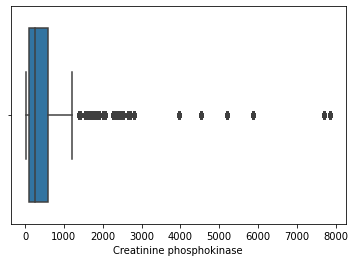

In [57]:
inspect_outliers(df, 'Creatinine phosphokinase')

I will cap the min and max accordingly

C:\Users\Randy\Venv\aiap\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


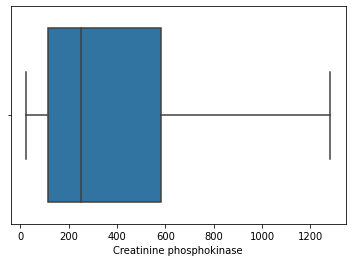

In [58]:
bound_outliers(df, 'Creatinine phosphokinase')

## Blood Pressure

Problem : Blood pressure is typically measured with 2 set of values but only 1 is present without specifying which

<AxesSubplot:>

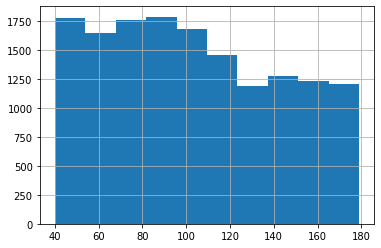

In [59]:
df['Blood Pressure'].hist()

C:\Users\Randy\Venv\aiap\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Blood Pressure'>

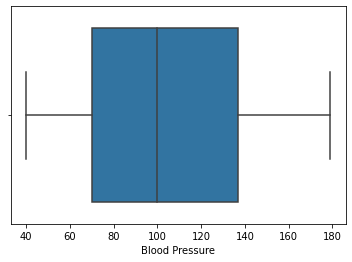

In [60]:
sns.boxplot(df['Blood Pressure'])

As I do not have medical knowledge and I am unable to identify if the BP is actually measuring diastolic or systolic pressure, I will assume it is actually measuring one of them and the measurements are done consistently. 

## Hemoglobin

Hemoglobin appears to be in range

C:\Users\Randy\Venv\aiap\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Hemoglobin'>

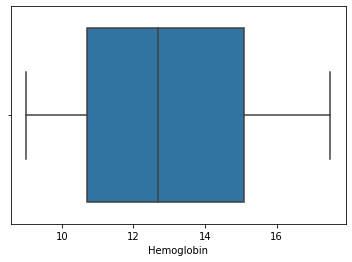

In [61]:
sns.boxplot(df.Hemoglobin)

## Height and Weight

I will inspect both height and weight together. 

C:\Users\Randy\Venv\aiap\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Height'>

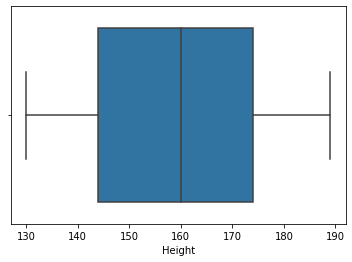

In [62]:
sns.boxplot(df.Height)

C:\Users\Randy\Venv\aiap\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Weight'>

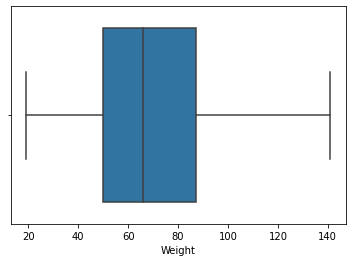

In [63]:
sns.boxplot(df.Weight)

In [64]:
df[df.Height<140]

,Survive,Gender,Smoke,Diabetes,Age,Ejection Fraction,Sodium,Creatinine,Pletelets,Creatinine phosphokinase,Blood Pressure,Hemoglobin,Height,Weight
3,0,Male,No,Normal,60,Low,136.0,0.90,228000.00,1282.5,136,15.3,130,48
12,0,Female,No,Normal,70,Low,141.0,0.90,358000.00,1202.0,139,16.6,132,36
17,1,Male,Yes,Normal,68,Low,140.0,0.90,289000.00,220.0,124,10.5,135,69
27,0,Male,Yes,Normal,45,Low,140.0,1.40,140000.00,1282.5,108,15.3,134,22
31,1,Male,No,Pre-diabetes,94,Low,134.0,1.83,263358.03,582.0,137,17.4,137,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14951,0,Male,No,Diabetes,63,Low,134.0,1.30,254000.00,514.0,149,9.5,139,61
14952,0,Male,Yes,Normal,40,Low,136.0,1.10,255000.00,90.0,72,14.2,132,33
14970,0,Male,Yes,Pre-diabetes,65,Low,137.0,0.90,281000.00,198.0,171,13.9,131,44
14980,1,Male,Yes,Pre-diabetes,60,Normal-High,131.0,1.10,443500.00,315.0,66,10.4,131,67


In [65]:
df[df.Weight<40]

,Survive,Gender,Smoke,Diabetes,Age,Ejection Fraction,Sodium,Creatinine,Pletelets,Creatinine phosphokinase,Blood Pressure,Hemoglobin,Height,Weight
12,0,Female,No,Normal,70,Low,141.0,0.9,358000.0,1202.0,139,16.6,132,36
14,0,Male,No,Normal,40,Low,137.0,0.9,255000.0,129.0,82,9.1,140,37
20,0,Male,No,Normal,42,Low,140.0,0.7,189000.0,64.0,109,13.2,155,37
27,0,Male,Yes,Normal,45,Low,140.0,1.4,140000.0,1282.5,108,15.3,134,22
38,0,Male,No,Normal,77,Low,137.0,1.1,406000.0,109.0,130,11.7,143,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14952,0,Male,Yes,Normal,40,Low,136.0,1.1,255000.0,90.0,72,14.2,132,33
14955,0,Male,Yes,Pre-diabetes,63,Low,136.0,0.9,179000.0,103.0,113,11.5,150,29
14962,0,Male,No,Pre-diabetes,40,Low,132.0,1.0,222000.0,582.0,43,15.2,154,37
14983,0,Male,No,Normal,42,Low,140.0,0.7,189000.0,64.0,104,16.5,148,34


Some values appear to be suspect like weight around 20kg and height around 130cm. However I will also assume that the values are correct and inspect BMI instead

# Feature Engineering

Without any domain knowledge, I am unable to come up with any specific features except for BMI. I will however use polynominal transformation to see if there are any hidden interaction and selection features from there

## BMI

As mentioned,seeing how in medical usage they are usually inspected as BMI instead of individually, I will introduce new feature BMI. I will see if the values are odd

Formula for BMI is [weight (kg) / height (cm) / height (cm)] x 10,000

In [66]:
df['BMI'] = (df.Weight/ df.Height/ df.Height) *10000

Normal range for BMI is 18.5 to 24.9

C:\Users\Randy\Venv\aiap\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='BMI'>

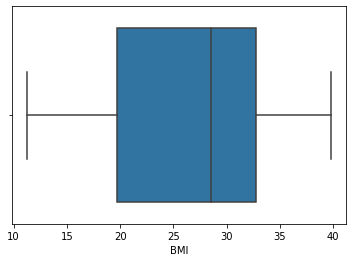

In [67]:
sns.boxplot(df.BMI)

<AxesSubplot:>

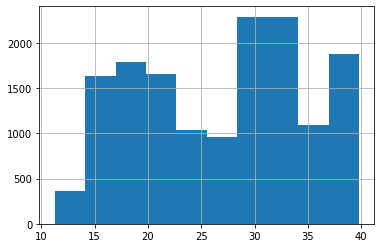

In [68]:
df.BMI.hist()

In [69]:
df.BMI.describe()

count    15000.000000
mean        26.939831
std          7.734126
min         11.242604
25%         19.675167
50%         28.493704
75%         32.713499
max         39.795918
Name: BMI, dtype: float64

This appears more to be in order

## Polynominal transformation

In [70]:
from sklearn.preprocessing import PolynomialFeatures 

In [71]:
# Using default degree 2 only as I do not want to introduce too many features
poly_transform = PolynomialFeatures(include_bias=False)

target = df['Survive']
num_cols = df.select_dtypes(include=['int','float'])
num_cols = num_cols.drop(columns='Survive')
cat_cols = df.select_dtypes(exclude=['int','float'])

In [72]:
num_cols_poly_transform = poly_transform.fit_transform(num_cols)

In [73]:
num_cols_poly_transform_colnames = poly_transform.get_feature_names_out()

In [74]:
len(num_cols_poly_transform_colnames)

65

In [75]:
len(num_cols_poly_transform[0])

65

In [76]:
pd.DataFrame(num_cols_poly_transform, columns=num_cols_poly_transform_colnames)

,Age,Sodium,Creatinine,Pletelets,Creatinine phosphokinase,Blood Pressure,Hemoglobin,Height,Weight,BMI,...,Hemoglobin^2,Hemoglobin Height,Hemoglobin Weight,Hemoglobin BMI,Height^2,Height Weight,Height BMI,Weight^2,Weight BMI,BMI^2
0,50.0,141.0,0.70,266000.0,185.0,105.0,12.3,180.0,93.0,28.703704,...,151.29,2214.0,1143.9,353.055556,32400.0,16740.0,5166.666667,8649.0,2669.444444,823.902606
1,75.0,134.0,2.15,224000.0,99.0,162.0,13.0,140.0,47.0,23.979592,...,169.00,1820.0,611.0,311.734694,19600.0,6580.0,3357.142857,2209.0,1127.040816,575.020825
2,80.0,135.0,1.30,192000.0,776.0,179.0,12.4,150.0,61.0,27.111111,...,153.76,1860.0,756.4,336.177778,22500.0,9150.0,4066.666667,3721.0,1653.777778,735.012346
3,60.0,136.0,0.90,228000.0,1282.5,136.0,15.3,130.0,48.0,28.402367,...,234.09,1989.0,734.4,434.556213,16900.0,6240.0,3692.307692,2304.0,1363.313609,806.694443
4,70.0,141.0,0.90,358000.0,1202.0,171.0,13.3,177.0,64.0,20.428357,...,176.89,2354.1,851.2,271.697150,31329.0,11328.0,3615.819209,4096.0,1307.414855,417.317774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,50.0,140.0,0.90,362000.0,298.0,109.0,11.8,178.0,51.0,16.096452,...,139.24,2100.4,601.8,189.938139,31684.0,9078.0,2865.168539,2601.0,820.919076,259.095782
14996,62.0,140.0,0.90,253000.0,231.0,141.0,14.6,171.0,114.0,38.986355,...,213.16,2496.6,1664.4,569.200780,29241.0,19494.0,6666.666667,12996.0,4444.444444,1519.935859
14997,61.0,141.0,0.90,229000.0,84.0,173.0,9.2,156.0,71.0,29.174885,...,84.64,1435.2,653.2,268.408941,24336.0,11076.0,4551.282051,5041.0,2071.416831,851.173912
14998,77.0,137.0,1.10,406000.0,109.0,154.0,11.3,130.0,32.0,18.934911,...,127.69,1469.0,361.6,213.964497,16900.0,4160.0,2461.538462,1024.0,605.917160,358.530864


In [77]:
num_cols_poly = pd.DataFrame(num_cols_poly_transform, columns=num_cols_poly_transform_colnames)

# Feature Selection

lets encode the cat cols (where applicable to see correlation to target) to check correlation to target

In [78]:
from sklearn.preprocessing import LabelEncoder

In [79]:
cat_cols.columns.to_list()

['Gender', 'Smoke', 'Diabetes', 'Ejection Fraction']

In [80]:
le_gender = LabelEncoder()
le_smoke = LabelEncoder()
le_diatetes = LabelEncoder()
le_eject = LabelEncoder()

In [81]:
df_temp = df.copy()
df_temp['Gender'] = le_gender.fit_transform(df_temp['Gender'])
df_temp['Smoke'] = le_smoke.fit_transform(df_temp['Smoke'])
df_temp['Diabetes'] = le_diatetes.fit_transform(df_temp['Diabetes'])
df_temp['Ejection Fraction'] = le_eject.fit_transform(df_temp['Ejection Fraction'])

In [82]:
df_temp

,Survive,Gender,Smoke,Diabetes,Age,Ejection Fraction,Sodium,Creatinine,Pletelets,Creatinine phosphokinase,Blood Pressure,Hemoglobin,Height,Weight,BMI
0,0,1,1,1,50,0,141.0,0.70,266000.0,185.0,105,12.3,180,93,28.703704
1,1,1,0,1,75,0,134.0,2.15,224000.0,99.0,162,13.0,140,47,23.979592
2,1,0,0,2,80,0,135.0,1.30,192000.0,776.0,179,12.4,150,61,27.111111
3,0,1,0,1,60,0,136.0,0.90,228000.0,1282.5,136,15.3,130,48,28.402367
4,0,0,0,1,70,0,141.0,0.90,358000.0,1202.0,171,13.3,177,64,20.428357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0,1,1,1,50,0,140.0,0.90,362000.0,298.0,109,11.8,178,51,16.096452
14996,1,1,1,1,62,0,140.0,0.90,253000.0,231.0,141,14.6,171,114,38.986355
14997,0,0,0,1,61,0,141.0,0.90,229000.0,84.0,173,9.2,156,71,29.174885
14998,0,1,0,1,77,0,137.0,1.10,406000.0,109.0,154,11.3,130,32,18.934911


<AxesSubplot:>

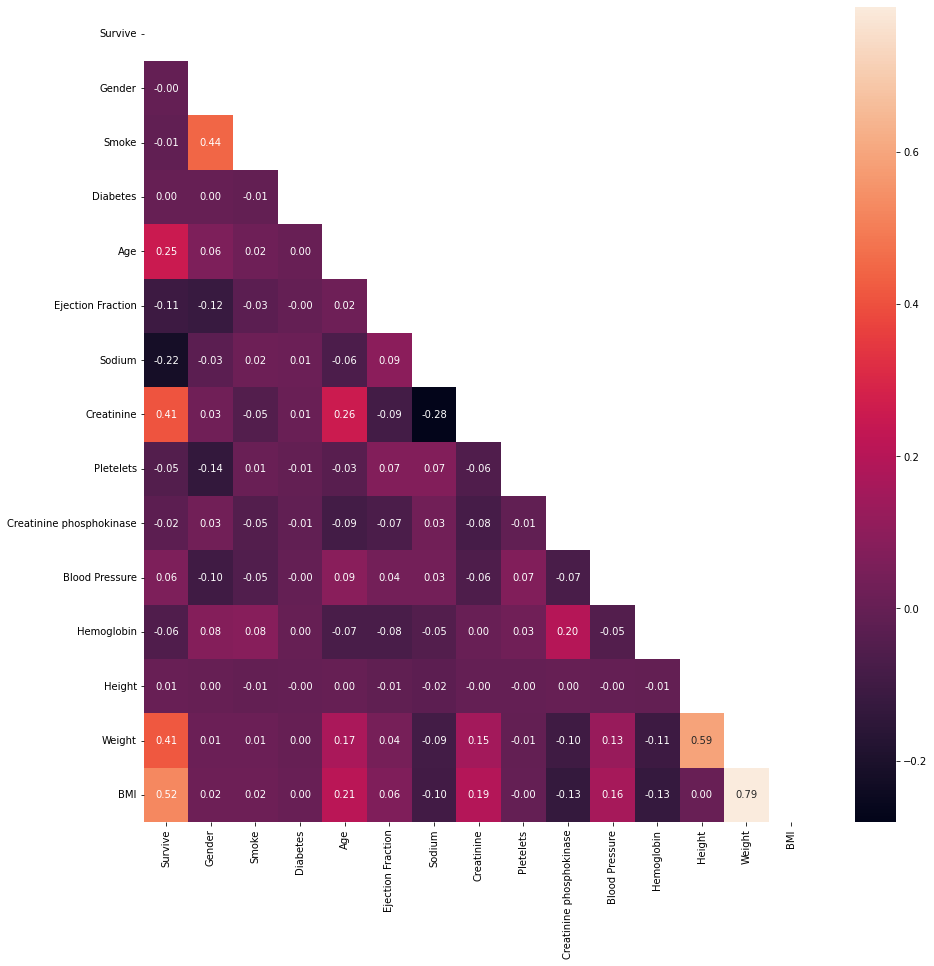

In [83]:
fig = plt.figure(figsize = (15,15))
mask = np.triu(df_temp.corr())
sns.heatmap(df_temp.corr(), annot=True, fmt='.2f', mask=mask)

In [84]:
df_transformed = num_cols_poly.join(cat_cols).join(target)

In [85]:
df_transformed.corr().columns

Index(['Age', 'Sodium', 'Creatinine', 'Pletelets', 'Creatinine phosphokinase',
       'Blood Pressure', 'Hemoglobin', 'Height', 'Weight', 'BMI', 'Age^2',
       'Age Sodium', 'Age Creatinine', 'Age Pletelets',
       'Age Creatinine phosphokinase', 'Age Blood Pressure', 'Age Hemoglobin',
       'Age Height', 'Age Weight', 'Age BMI', 'Sodium^2', 'Sodium Creatinine',
       'Sodium Pletelets', 'Sodium Creatinine phosphokinase',
       'Sodium Blood Pressure', 'Sodium Hemoglobin', 'Sodium Height',
       'Sodium Weight', 'Sodium BMI', 'Creatinine^2', 'Creatinine Pletelets',
       'Creatinine Creatinine phosphokinase', 'Creatinine Blood Pressure',
       'Creatinine Hemoglobin', 'Creatinine Height', 'Creatinine Weight',
       'Creatinine BMI', 'Pletelets^2', 'Pletelets Creatinine phosphokinase',
       'Pletelets Blood Pressure', 'Pletelets Hemoglobin', 'Pletelets Height',
       'Pletelets Weight', 'Pletelets BMI', 'Creatinine phosphokinase^2',
       'Creatinine phosphokinase Blood Pre

<AxesSubplot:>

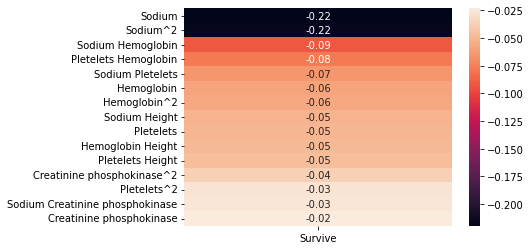

In [86]:
#fig = plt.figure(figsize = (10,10))
sns.heatmap(df_transformed.corr()[['Survive']].sort_values('Survive').head(15), annot=True, fmt='.2f')

<AxesSubplot:>

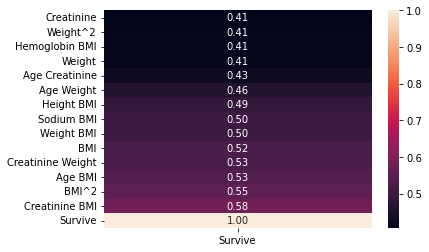

In [87]:
#fig = plt.figure(figsize = (10,10))
sns.heatmap(df_transformed.corr()[['Survive']].sort_values('Survive').tail(15), annot=True, fmt='.2f')

Looks like most of the features and interactions do not correlate highly with the target feature. We will just keep BMI and drop the rest.

array([[<AxesSubplot:title={'center':'Survive'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Sodium'}>],
       [<AxesSubplot:title={'center':'Creatinine'}>,
        <AxesSubplot:title={'center':'Pletelets'}>,
        <AxesSubplot:title={'center':'Creatinine phosphokinase'}>],
       [<AxesSubplot:title={'center':'Blood Pressure'}>,
        <AxesSubplot:title={'center':'Hemoglobin'}>,
        <AxesSubplot:title={'center':'Height'}>],
       [<AxesSubplot:title={'center':'Weight'}>,
        <AxesSubplot:title={'center':'BMI'}>, <AxesSubplot:>]],
      dtype=object)

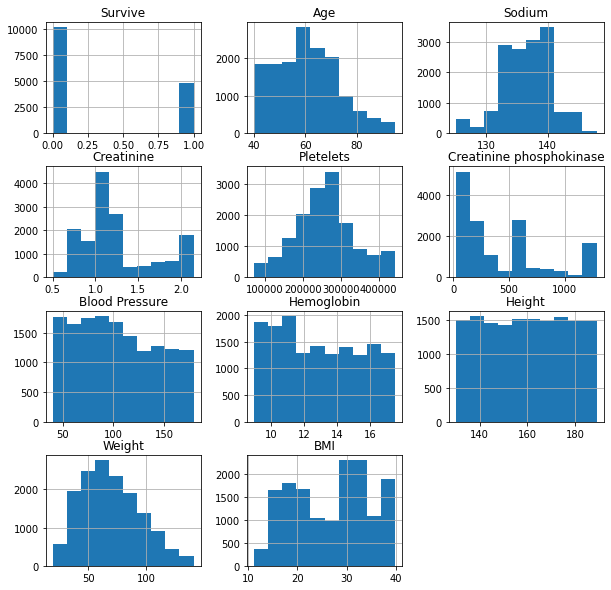

In [88]:
df.hist(figsize=(10,10))

# Pipeline

In [89]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

<b>All changes that was done</b>

Target:
- replaced No and Yes to 0 and 1
- convert to int

Smoke
- replaced NO to no, YES to Yes
    
Age
- flipped sign if negative
    
Ejection
- replaced L to Low, N to normal
- replaced High to Normal 
- Replace all normal to normal-high

Numerical features : Sodium, Creatinine, Pletelets, CK,Blood Pressure, Hemoglobin, Height , Weight

Numerical features
- Bound all outliers
- impute with median if missing

New col:
- BMI

In [90]:
TARGET = ['Survive']

CAT_FEATURES = ['Gender','Smoke','Diabetes','Ejection Fraction']

ORI_NUM_FEATURES = ['Sodium', 'Creatinine', 'Pletelets', 'Creatinine phosphokinase','Blood Pressure', 'Hemoglobin', 'Height' , 'Weight']
TOTAL_NUM_FEATURES = ['Sodium', 'Creatinine', 'Pletelets', 'Creatinine phosphokinase','Blood Pressure', 'Hemoglobin', 'Height' , 'Weight', 'BMI']

TOTAL_FEATURES = CAT_FEATURES + TOTAL_NUM_FEATURES
TOTAL_FEATURES_W_TARGET = TOTAL_FEATURES + TARGET

In [91]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [92]:
transform_pipe = ColumnTransformer([
    ('ss',StandardScaler(),TOTAL_NUM_FEATURES),
    ('ohe',OneHotEncoder(drop='first'),CAT_FEATURES)
])

In [93]:
y = df.pop('Survive')
X = df

In [94]:
y

0        0
1        1
2        1
3        0
4        0
        ..
14995    0
14996    1
14997    0
14998    0
14999    1
Name: Survive, Length: 15000, dtype: int32

In [95]:
X

,Gender,Smoke,Diabetes,Age,Ejection Fraction,Sodium,Creatinine,Pletelets,Creatinine phosphokinase,Blood Pressure,Hemoglobin,Height,Weight,BMI
0,Male,Yes,Normal,50,Low,141.0,0.70,266000.0,185.0,105,12.3,180,93,28.703704
1,Male,No,Normal,75,Low,134.0,2.15,224000.0,99.0,162,13.0,140,47,23.979592
2,Female,No,Pre-diabetes,80,Low,135.0,1.30,192000.0,776.0,179,12.4,150,61,27.111111
3,Male,No,Normal,60,Low,136.0,0.90,228000.0,1282.5,136,15.3,130,48,28.402367
4,Female,No,Normal,70,Low,141.0,0.90,358000.0,1202.0,171,13.3,177,64,20.428357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,Male,Yes,Normal,50,Low,140.0,0.90,362000.0,298.0,109,11.8,178,51,16.096452
14996,Male,Yes,Normal,62,Low,140.0,0.90,253000.0,231.0,141,14.6,171,114,38.986355
14997,Female,No,Normal,61,Low,141.0,0.90,229000.0,84.0,173,9.2,156,71,29.174885
14998,Male,No,Normal,77,Low,137.0,1.10,406000.0,109.0,154,11.3,130,32,18.934911


In [96]:
X_train, X_temp, y_train, y_temp = train_test_split(X,y, test_size=VAL_RATIO, random_state=RANDOM_SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp, test_size=TEST_RATIO, random_state=RANDOM_SEED)

In [97]:
print(f'Shape of X_train is {X_train.shape}')
print(f'Shape of X_val is {X_val.shape}')
print(f'Shape of X_test is {X_test.shape}')
print(f'Shape of y_train is {y_train.shape}')
print(f'Shape of y_val is {y_val.shape}')
print(f'Shape of y_test is {y_test.shape}')

Shape of X_train is (12000, 14)
Shape of X_val is (1500, 14)
Shape of X_test is (1500, 14)
Shape of y_train is (12000,)
Shape of y_val is (1500,)
Shape of y_test is (1500,)


In [98]:
X_train.columns.to_list()

['Gender',
 'Smoke',
 'Diabetes',
 'Age',
 'Ejection Fraction',
 'Sodium',
 'Creatinine',
 'Pletelets',
 'Creatinine phosphokinase',
 'Blood Pressure',
 'Hemoglobin',
 'Height',
 'Weight',
 'BMI']

In [99]:
# X_train = transform_pipe.fit_transform(X_train)
# X_test = transform_pipe.transform(X_test)

# Modelling

In [100]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_validate

In [101]:
lgbm = LGBMClassifier(random_state=RANDOM_SEED)
rfc = RandomForestClassifier(random_state=RANDOM_SEED)
svc = SVC(random_state=RANDOM_SEED)
knn = KNeighborsClassifier()
logreg = LogisticRegression()

In [102]:
survive_pipe_lgbm = Pipeline([
    ('transform',transform_pipe),
    ('lgbm',lgbm)
])
survive_pipe_rfc = Pipeline([
    ('transform',transform_pipe),
    ('rfc',rfc)
])
survive_pipe_svc = Pipeline([
    ('transform',transform_pipe),
    ('svc',svc)
])
survive_pipe_knn = Pipeline([
    ('transform',transform_pipe),
    ('knn',knn)
])
survive_pipe_logreg = Pipeline([
    ('transform',transform_pipe),
    ('logreg',logreg)
])

In [103]:
pipeline_dict = {survive_pipe_rfc : 'rfc', survive_pipe_svc : 'svc', survive_pipe_lgbm: 'lgbm', survive_pipe_knn : 'knn', survive_pipe_logreg: 'logreg'}

In [104]:
model_list = list(pipeline_dict.values())

In [105]:
import time

In [106]:
now = time.time()

In [107]:
then = time.time()

In [108]:
diff = then - now
print(diff)

0.016000986099243164


In [109]:
for pipe, model_name in pipeline_dict.items():
    now = time.time()
    training_samples = 10000
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)
    
    model_cv_score = cross_validate(pipe,X_train[:training_samples], y_train[:training_samples], 
                                    cv=CV, 
                                    n_jobs = -1,
                                    return_train_score=True, 
                                    scoring='accuracy')
    
    print('')
    print('\n'+ str('*'*50))
    print('Model is ', model_name)
    print('*'*50)
    
    print(f'Classifcation report :\n{classification_report(y_val, y_pred)}')
    print(f'Average CV train acc score : \n {model_cv_score["train_score"].mean()} ')
    print(f'Average CV test acc score : \n {model_cv_score["test_score"].mean()} ')
    print(f'ROC AUC score :\n {roc_auc_score(y_val, y_pred)}')    
    then = time.time()
    diff = then - now
    print(f'Time taken to run results is {diff}')
    #plot_results(mse_train,model_cv_rmse, name)



**************************************************
Model is  rfc
**************************************************
Classifcation report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       996
           1       1.00      1.00      1.00       504

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500

Average CV train acc score : 
 1.0 
Average CV test acc score : 
 0.9999 
ROC AUC score :
 1.0
Time taken to run results is 3.8289942741394043


**************************************************
Model is  svc
**************************************************
Classifcation report :
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       996
           1       0.96      0.89      0.92       504

    accuracy                           0.95      1500
   macro avg       0.95      0

In [110]:
for pipe, model_name in pipeline_dict.items():
    now = time.time()    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
        
    print('\n'+ str('*'*50))
    print('Model is ', model_name)
    print('*'*50)
    
    print(f'Classifcation report :\n{classification_report(y_test, y_pred)}')
    print(f'ROC AUC score :\n {roc_auc_score(y_test, y_pred)}')    
    then = time.time()
    diff = then - now
    print(f'Time taken to run results is {diff}')


**************************************************
Model is  rfc
**************************************************
Classifcation report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1010
           1       1.00      1.00      1.00       490

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500

ROC AUC score :
 1.0
Time taken to run results is 1.0080111026763916

**************************************************
Model is  svc
**************************************************
Classifcation report :
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1010
           1       0.97      0.93      0.95       490

    accuracy                           0.97      1500
   macro avg       0.97      0.96      0.96      1500
weighted avg       0.97      0.97      0.97      150

# Delete

In [111]:
import os
print(os.getcwd())
pickle_path = os.path.join(os.getcwd(),'src','model','pipeline.pkl')

C:\Users\Randy\GitHub\AIAP


In [112]:
X_train

,Gender,Smoke,Diabetes,Age,Ejection Fraction,Sodium,Creatinine,Pletelets,Creatinine phosphokinase,Blood Pressure,Hemoglobin,Height,Weight,BMI
9839,Male,No,Pre-diabetes,60,Low,140.0,1.7,194000.00,231.0,114,9.3,130,47,27.810651
9680,Female,Yes,Normal,72,Low,138.0,1.7,443500.00,328.0,148,11.7,182,103,31.095278
7093,Male,Yes,Pre-diabetes,44,Low,130.0,1.6,263358.03,582.0,168,13.8,179,50,15.605006
11293,Female,No,Normal,62,Low,133.0,0.7,283000.00,655.0,54,11.7,172,49,16.563007
820,Female,No,Pre-diabetes,50,Low,142.0,0.9,75000.00,1282.5,89,11.4,151,62,27.191790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191,Female,No,Normal,70,Low,136.0,1.7,293000.00,69.0,85,12.8,165,88,32.323232
13418,Female,No,Pre-diabetes,60,Low,144.0,2.1,365000.00,1282.5,66,16.3,151,52,22.806017
5390,Male,No,Normal,51,Low,140.0,0.7,406000.00,78.0,45,14.7,147,69,31.931140
860,Male,No,Normal,63,Low,137.0,0.7,73000.00,1282.5,72,10.5,138,41,21.529091


In [113]:
import joblib
model = joblib.load(pickle_path)
model.predict(X_train)

array([0, 1, 0, ..., 0, 0, 1])

In [114]:
################################################################################################################################################

In [115]:
df = df_ori.copy()

In [116]:
df.isna().sum()

ID                            0
Survive                       0
Gender                        0
Smoke                         0
Diabetes                      0
Age                           0
Ejection Fraction             0
Sodium                        0
Creatinine                  499
Pletelets                     0
Creatinine phosphokinase      0
Blood Pressure                0
Hemoglobin                    0
Height                        0
Weight                        0
Favorite color                0
dtype: int64

In [117]:
from sklearn.impute import SimpleImputer
imputer_median = SimpleImputer(strategy='median')

In [118]:
creatinine_array = np.array(df.Creatinine).reshape(-1,1)

In [119]:
creatinine_array_processed = imputer_median.fit_transform(np.array(df.Creatinine).reshape(-1,1))

In [120]:
pd.DataFrame(creatinine_array_processed).isna().sum()

0    0
dtype: int64

In [121]:
_list = ["Male","Yes",
  "Normal",
  21,
  "Low",
  120,
  0.2,
  266000,
  100,
  105,
  16.3,
  185,
  80,
  23.374726077428782
]

In [122]:
_list

['Male',
 'Yes',
 'Normal',
 21,
 'Low',
 120,
 0.2,
 266000,
 100,
 105,
 16.3,
 185,
 80,
 23.374726077428782]

In [123]:
features = ['Gender','Smoke','Diabetes','Age','Ejection Fraction','Sodium','Creatinine','Pletelets','Creatinine phosphokinase','Blood Pressure','Hemoglobin','Height','Weight','BMI']

In [124]:
len(features)

14

In [125]:
np.array(_list).reshape(1,-1)

array([['Male', 'Yes', 'Normal', '21', 'Low', '120', '0.2', '266000',
        '100', '105', '16.3', '185', '80', '23.374726077428782']],
      dtype='<U32')

In [126]:
list_transform = np.array(_list).reshape(1,-1)

In [127]:
TOTAL_NUM_FEATURES = ['Age','Sodium','Creatinine','Pletelets','Creatinine phosphokinase','Blood Pressure','Hemoglobin','Height','Weight','BMI']

In [128]:
TOTAL_FEATURES

['Gender',
 'Smoke',
 'Diabetes',
 'Ejection Fraction',
 'Sodium',
 'Creatinine',
 'Pletelets',
 'Creatinine phosphokinase',
 'Blood Pressure',
 'Hemoglobin',
 'Height',
 'Weight',
 'BMI']

In [129]:
feature_dict = {k:v for k,v in zip(range(len(features)),
                                  features)}

In [130]:
len(TOTAL_FEATURES)

13

In [131]:
pd.DataFrame(list_transform).rename(columns=feature_dict)

,Gender,Smoke,Diabetes,Age,Ejection Fraction,Sodium,Creatinine,Pletelets,Creatinine phosphokinase,Blood Pressure,Hemoglobin,Height,Weight,BMI
0,Male,Yes,Normal,21,Low,120,0.2,266000,100,105,16.3,185,80,23.374726077428782


In [132]:
poly_creatinine = PolynomialFeatures(include_bias=False, interaction_only=True)


In [133]:
df_transformed.columns

Index(['Age', 'Sodium', 'Creatinine', 'Pletelets', 'Creatinine phosphokinase',
       'Blood Pressure', 'Hemoglobin', 'Height', 'Weight', 'BMI', 'Age^2',
       'Age Sodium', 'Age Creatinine', 'Age Pletelets',
       'Age Creatinine phosphokinase', 'Age Blood Pressure', 'Age Hemoglobin',
       'Age Height', 'Age Weight', 'Age BMI', 'Sodium^2', 'Sodium Creatinine',
       'Sodium Pletelets', 'Sodium Creatinine phosphokinase',
       'Sodium Blood Pressure', 'Sodium Hemoglobin', 'Sodium Height',
       'Sodium Weight', 'Sodium BMI', 'Creatinine^2', 'Creatinine Pletelets',
       'Creatinine Creatinine phosphokinase', 'Creatinine Blood Pressure',
       'Creatinine Hemoglobin', 'Creatinine Height', 'Creatinine Weight',
       'Creatinine BMI', 'Pletelets^2', 'Pletelets Creatinine phosphokinase',
       'Pletelets Blood Pressure', 'Pletelets Hemoglobin', 'Pletelets Height',
       'Pletelets Weight', 'Pletelets BMI', 'Creatinine phosphokinase^2',
       'Creatinine phosphokinase Blood Pre

In [134]:
without_creatinine = [col for col in df_transformed.columns.to_list() if 'Creatinine' not in col]

In [135]:
without_creatinine = [col for col in without_creatinine if col not in num_cols.columns.to_list() and col not in cat_cols.columns.to_list() and 'Survive' not in col]

In [136]:
df_final = df_transformed.drop(columns=(without_creatinine))

In [137]:
df_final.columns.to_list()

['Age',
 'Sodium',
 'Creatinine',
 'Pletelets',
 'Creatinine phosphokinase',
 'Blood Pressure',
 'Hemoglobin',
 'Height',
 'Weight',
 'BMI',
 'Age Creatinine',
 'Age Creatinine phosphokinase',
 'Sodium Creatinine',
 'Sodium Creatinine phosphokinase',
 'Creatinine^2',
 'Creatinine Pletelets',
 'Creatinine Creatinine phosphokinase',
 'Creatinine Blood Pressure',
 'Creatinine Hemoglobin',
 'Creatinine Height',
 'Creatinine Weight',
 'Creatinine BMI',
 'Pletelets Creatinine phosphokinase',
 'Creatinine phosphokinase^2',
 'Creatinine phosphokinase Blood Pressure',
 'Creatinine phosphokinase Hemoglobin',
 'Creatinine phosphokinase Height',
 'Creatinine phosphokinase Weight',
 'Creatinine phosphokinase BMI',
 'Gender',
 'Smoke',
 'Diabetes',
 'Ejection Fraction',
 'Survive']

In [138]:
df_final = df_final.drop(columns=['Age Creatinine phosphokinase','Sodium Creatinine phosphokinase','Pletelets Creatinine phosphokinase','Creatinine phosphokinase^2',
               'Creatinine phosphokinase Blood Pressure','Creatinine phosphokinase Hemoglobin','Creatinine phosphokinase Height','Creatinine phosphokinase Weight',
              'Creatinine phosphokinase BMI'])

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Sodium'}>,
        <AxesSubplot:title={'center':'Creatinine'}>,
        <AxesSubplot:title={'center':'Pletelets'}>,
        <AxesSubplot:title={'center':'Creatinine phosphokinase'}>],
       [<AxesSubplot:title={'center':'Blood Pressure'}>,
        <AxesSubplot:title={'center':'Hemoglobin'}>,
        <AxesSubplot:title={'center':'Height'}>,
        <AxesSubplot:title={'center':'Weight'}>,
        <AxesSubplot:title={'center':'BMI'}>],
       [<AxesSubplot:title={'center':'Age Creatinine'}>,
        <AxesSubplot:title={'center':'Sodium Creatinine'}>,
        <AxesSubplot:title={'center':'Creatinine^2'}>,
        <AxesSubplot:title={'center':'Creatinine Pletelets'}>,
        <AxesSubplot:title={'center':'Creatinine Creatinine phosphokinase'}>],
       [<AxesSubplot:title={'center':'Creatinine Blood Pressure'}>,
        <AxesSubplot:title={'center':'Creatinine Hemoglobin'}>,
        <AxesSubplot:title={'ce

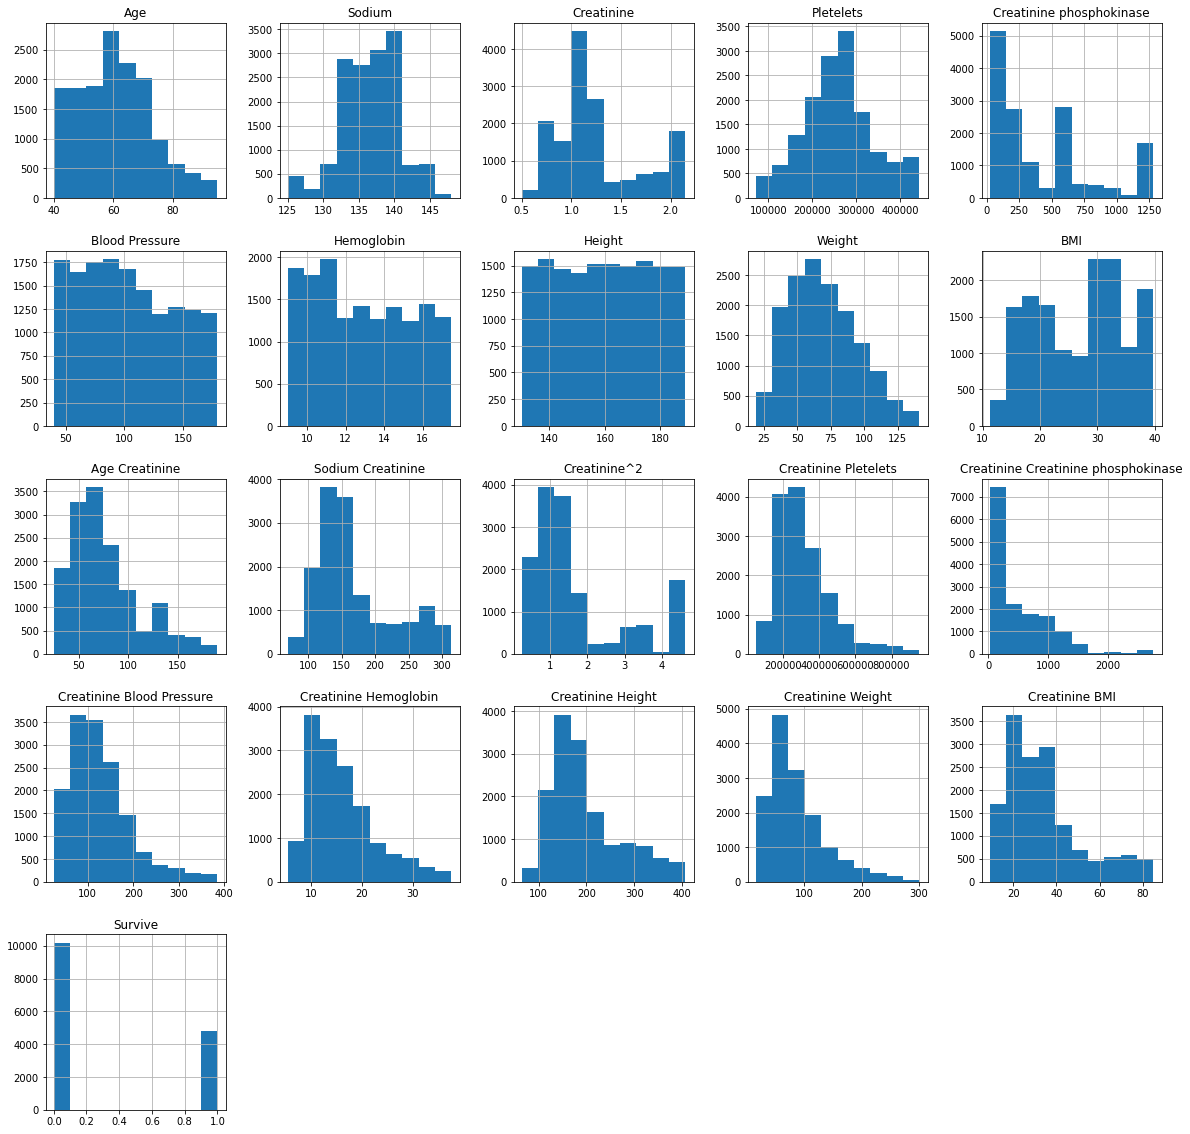

In [139]:
df_final.hist(figsize=(20,20))

In [140]:
class ConvertToConsistentCat(BaseEstimator, TransformerMixin):
    def __init__(self, items=None):
        if items is None: items = []
        self.l = items
    def fit(self, X , y=None):
        # does not fit
        return self
    def transform(self, X):
        #X = X.copy()
        temp_cols = X.columns.to_list()
        temp_cols.append('healthy')
        new_cols = {k:v for k,v in zip(range(len(temp_cols)),temp_cols)}
        healthy = X.apply(lambda row: determine_healthy(row), axis=1)
        combined_df = pd.DataFrame(np.c_[X, healthy]).rename(columns=new_cols)
        return combined_df

In [141]:
def bound_outliers(df, col, boxplot= True):
    """
    Censors outliers to within the boxplot inner fences and plots
    the boxplot afterwards if set to true

    args:
    df : dataframe
    col: the col of the dataframe
    
    returns:
    none
    """
    df_col_max = return_min_max_boxplot(df, col, 'max')
    df_col_min = return_min_max_boxplot(df, col, 'min')
    df[col] = np.where(df[col]>=df_col_max, df_col_max,df[col])
    df[col] = np.where(df[col]<=df_col_min, df_col_min,df[col])
    if boxplot:
        sns.boxplot(df[col])

In [142]:
class BoundOutliers(BaseEstimator, TransformerMixin):
    def __init__(self, items=None):
        if items is None: items = []
        self.l = items
    def fit(self, X , y=None):
        # does not fit
        return self
    def transform(self, X):
        #X = X.copy()
        temp_cols = X.columns.to_list()
        temp_cols.append('healthy')
        new_cols = {k:v for k,v in zip(range(len(temp_cols)),temp_cols)}
        healthy = X.apply(lambda row: determine_healthy(row), axis=1)
        combined_df = pd.DataFrame(np.c_[X, healthy]).rename(columns=new_cols)
        return combined_df

In [143]:
class FlipNegativeSign(BaseEstimator, TransformerMixin):
    def __init__(self, items=None):
        if items is None: items = []
        self.l = items
    def fit(self, X , y=None):
        return self
    def transform(self, X):
        #X = X.copy()
        temp_cols = X.columns.to_list()
        temp_cols.append('healthy')
        new_cols = {k:v for k,v in zip(range(len(temp_cols)),temp_cols)}
        healthy = X.apply(lambda row: determine_healthy(row), axis=1)
        combined_df = pd.DataFrame(np.c_[X, healthy]).rename(columns=new_cols)
        return combined_df

In [144]:
# df.Survive = df.Survive.str.replace('No','0')
# df.Survive = df.Survive.str.replace('Yes','1')
# df.Survive = df.Survive.astype('int')

# df.Smoke = df.Smoke.replace('NO','No')
# df.Smoke = df.Smoke.replace('YES','Yes')

# df.Age = np.where(df.Age<0,-df.Age, df.Age)

# df['Ejection Fraction'] = df['Ejection Fraction'].replace('L','Low').replace('N','Normal')
# df['Ejection Fraction'] = df['Ejection Fraction'].replace('High','Normal').replace('Normal','Normal-High')

# Sodium, Creatinine, Pletelets, CK,Blood Pressure, Hemoglobin, Height , Weight,

# New Col: BMI